In [1]:
pip install tensorflow

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 809.0 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 36.2 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 41.3 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 29.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

2024-07-04 03:10:31.663870: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-04 03:10:31.666879: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-04 03:10:31.675907: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 03:10:31.692953: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 03:10:31.692996: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-04 03:10:31.705051: I tensorflow/core/platform/cpu_feature_guard.cc:

In [3]:
#loading data
file_1="/workspaces/State-of-Health-Estimation-Battery/Dataset/B0005_dis_dataset.csv"
dataset=pd.read_csv(file_1)

C_max=2

#renaming columns for simplicity
dataset.columns=['cycle',"capacity",'voltage', 'current','temperature', 'current_load', 'voltage_load',"time"]
dataset["current_load"]= abs(dataset["current_load"])

#removing ideling / starting and ending current level data  
df=dataset[(dataset.current_load>=0.006)].reset_index(drop=True)

# converting time seconds->hour
df["time"]=df["time"]/3600

#calculate Soc for each cycle
cycle_count=df["cycle"].unique()
Soc_list=[]

# Update Soc for each reading within each cycle using Coulomb counting
for cycle in cycle_count:
    cycle_data = df[df['cycle'] == cycle]
    
    cumulative_Soc = [sum(cycle_data["capacity"])/len(cycle_data["capacity"])]
    
    for i in range(1, len(cycle_data)):
        
        delta_time = cycle_data['time'].iloc[i-1] - cycle_data['time'].iloc[i]
        
        delta_charge = cycle_data['current'].iloc[i] * delta_time
        
        cumulative_Soc.append(cumulative_Soc[-1] -delta_charge)
        
    Soc_list.extend(cumulative_Soc)

#DOD is the opposite of the soc 
df["Soc"] = [(q / C_max) for q in Soc_list]
df["Soh"]=df["capacity"]/C_max


# selecting parameters 
att_=["cycle","capacity","voltage","current","temperature","current_load","voltage_load","time","Soc"]
att=["cycle","current_load","voltage_load","Soc","time"]
X_axis="cycle"

X = df[att]
Y = df[["Soh"]]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [5]:
#sorting data wrt to index
X_test = X_test.sort_index(axis=0)
X_train= X_train.sort_index(axis=0)
y_train= y_train.sort_index(axis=0)
y_test = y_test.sort_index(axis=0)

In [6]:
#define lstm model we have 4 input variable so 3 layers
#model.add(LSTM(128, activation='tanh',recurrent_activation='sigmoid',return_sequences=True,input_shape=(X_train.shape[1],1)))
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, activation='tanh', recurrent_activation='sigmoid', return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.25))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(64))
model.add(Dropout(0.25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,057 (582.25 KB)

 Trainable params: 149,057 (582.25 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [8]:
model.fit(X_train, y_train, epochs=200,batch_size=32, verbose=1,validation_split=0.2, callbacks=[early_stopping])

Epoch 1/200


790/790 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0216 - val_loss: 3.2900e-04
Epoch 2/200
790/790 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0032 - val_loss: 8.4127e-04
Epoch 3/200
790/790 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0024 - val_loss: 8.5183e-04
Epoch 4/200
790/790 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0016 - val_loss: 3.7689e-04
Epoch 5/200
790/790 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0010 - val_loss: 2.0077e-04
Epoch 6/200
790/790 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 5.8566e-04 - val_loss: 3.0489e-04
Epoch 7/200
790/790 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 3.2271e-04 - val_loss: 1.1525e-04
Epoch 8/200
790/790 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 2.0089e-04 - val_loss: 4.3750e-05
Epoch 9/200
790/790 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1.4902e-04 - val_loss: 4.9942e-05
Epoch 10/200
790/790 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1.2253e-04 - val_loss: 3.2270e-04
Epoch 11/200
790/790 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1.1854e-04 - val_lo

In [9]:
y_pred_1 = model.predict(X_test, verbose=1)

424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


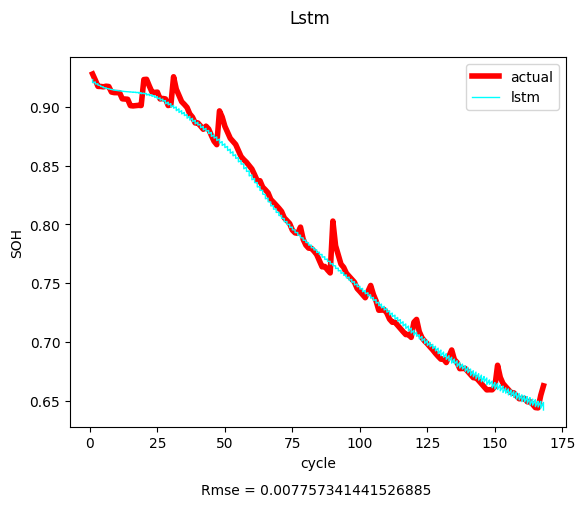

0.007757341441526885


In [10]:
plt.plot(X_test["cycle"],y_test,color='red',label='actual',linewidth=4)
plt.plot(X_test["cycle"],y_pred_1,color='cyan',label="lstm",linewidth=1)
plt.xlabel("cycle")
plt.ylabel("SOH")
rmse="Rmse = "+str(np.sqrt(metrics.mean_squared_error(y_test, y_pred_1)))
plt.figtext(0.33, -0.03, rmse, fontsize=10)
plt.legend(loc="upper right")
plt.suptitle("Lstm")
plt.show()
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred_1)))

In [ ]:
0.00869657655332687